In [13]:
import numpy as np
import circe as ci
import scanpy as sc
import scipy as sp
import warnings
import pandas as pd 
warnings.filterwarnings('ignore')

In [2]:
regions = ['AMY','HIP','PFC']
celltypes = ['OPC-Oligo', 'Immune','Astro-Epen','Vascular']


In [ ]:
region = 'AMY'
celltype = 'Vascular'
base_name = f"{region}_{celltype}"


In [ ]:
base_name

In [ ]:
adata = sc.read_h5ad(f"/data2st1/junyi/output/motif/{base_name}.h5ads")

In [ ]:
adata

In [ ]:
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.filter_cells(adata, min_genes=200)


In [ ]:
adata.var.index=adata.var.index.str.replace(":", "_").str.replace("-", "_")

In [ ]:
# Column to use for stratification
if adata.shape[0] > 10000:
    stratify_column = 'sample'
    stratify_column = 'sample'

    # Number of cells to sample from each group
    n_samples_per_group = 2000

    # Perform stratified sampling
    sampled_indices = (
        adata.obs
        .groupby(stratify_column, group_keys=False)
        .apply(lambda x: x.sample(min(n_samples_per_group, len(x))))
        .index
    )
    adata  = adata[sampled_indices, :]



In [ ]:
%%capture
adata = ci.add_region_infos(adata)


In [ ]:
%%capture
ci.compute_atac_network(
    adata, #metacells,
    organism="mouse",
)

In [ ]:
%%capture
final_score = ci.sliding_graphical_lasso(
    adata,
    n_samples=50,
    n_samples_maxtry=100,
    max_alpha_iteration=500,
    verbose=True
)
adata.varp['atac_network'] = final_score


In [ ]:
adata.varp['atac_network']

In [ ]:
circe_network = ci.extract_atac_links(adata) #metacells)
circe_network.head(10)


In [ ]:
circe_network.to_csv(f"/data2st1/junyi/output/cicre/{base_name}_circe_network.csv")

In [ ]:
ccans = ci.find_ccans(circe_network, seed=0)


In [ ]:
ccans.to_csv(f"/data2st1/junyi/output/cicre/{base_name}_ccans.csv")

In [ ]:
adata = ci.add_ccans(adata)


In [ ]:
adata.var.head()


In [135]:
from matplotlib import pyplot as plt


This CCAN module is on the chromosome: chr2
***** WARNING: File /data2st1/junyi/generegion_vM33/genebody.sorted.bed has inconsistent naming convention for record:
GL456210.1	9123	58882	.	-	ENSMUSG00000079800	ENSMUSG00000079800.3	genebody

***** WARNING: File /data2st1/junyi/generegion_vM33/genebody.sorted.bed has inconsistent naming convention for record:
GL456210.1	9123	58882	.	-	ENSMUSG00000079800	ENSMUSG00000079800.3	genebody

This CCAN module is on the chromosome: chr2
***** WARNING: File /data2st1/junyi/generegion_vM33/genebody.sorted.bed has inconsistent naming convention for record:
GL456210.1	9123	58882	.	-	ENSMUSG00000079800	ENSMUSG00000079800.3	genebody

***** WARNING: File /data2st1/junyi/generegion_vM33/genebody.sorted.bed has inconsistent naming convention for record:
GL456210.1	9123	58882	.	-	ENSMUSG00000079800	ENSMUSG00000079800.3	genebody

This CCAN module is on the chromosome: chr2
***** WARNING: File /data2st1/junyi/generegion_vM33/genebody.sorted.bed has inconsistent

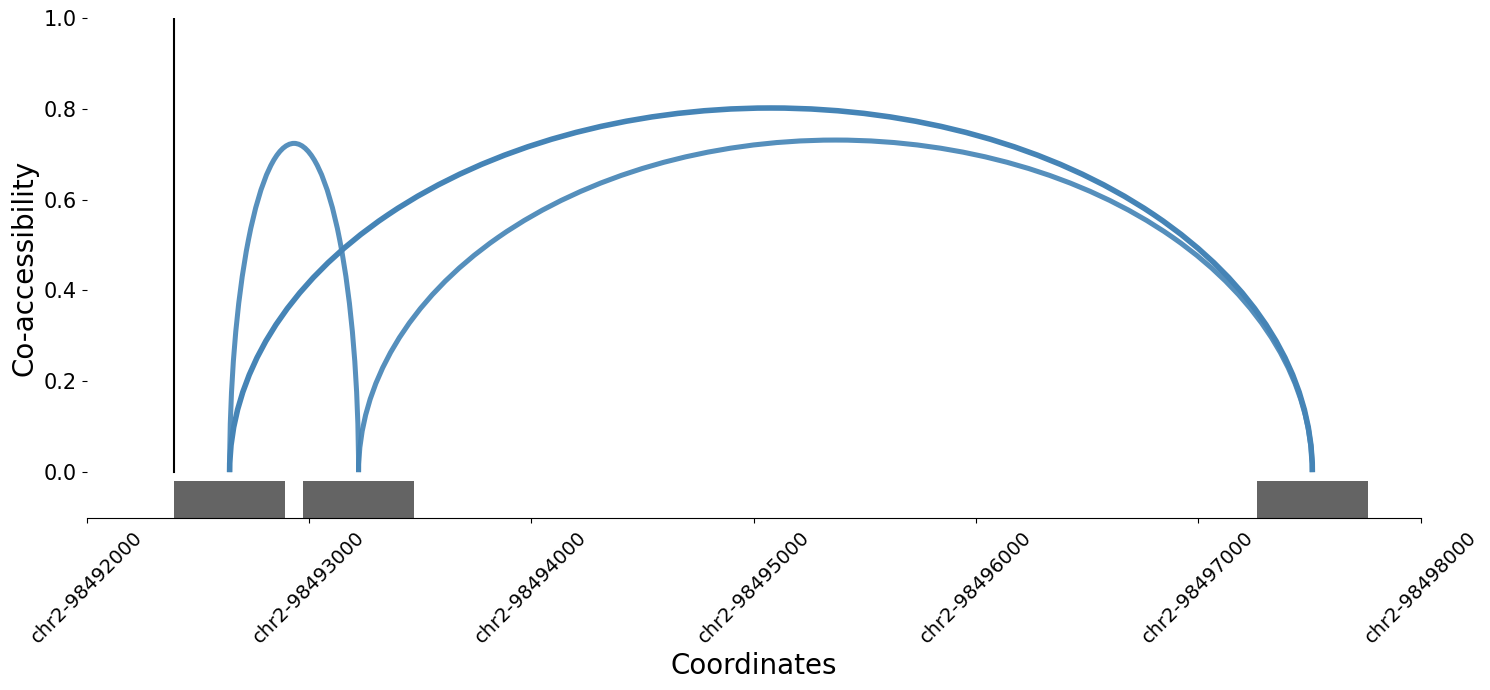

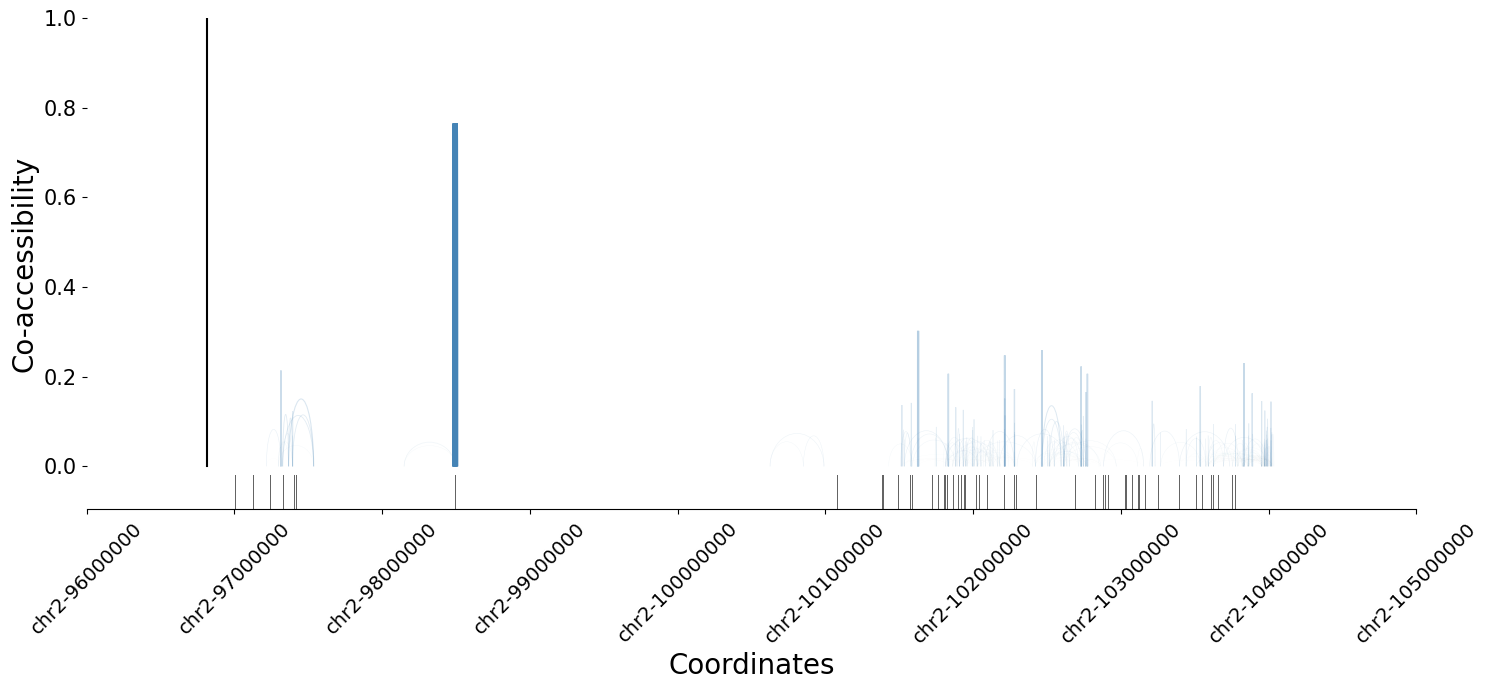

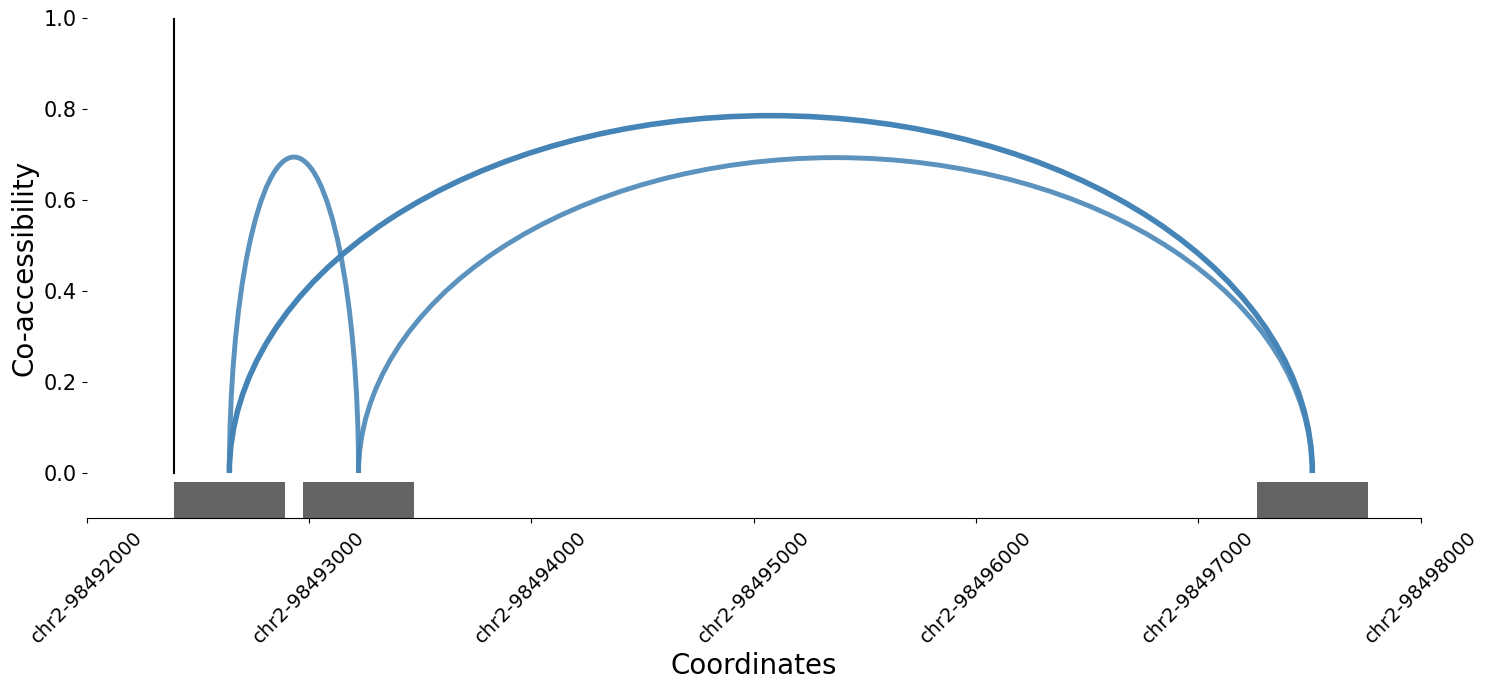

In [177]:
celltypes = ['Neuron']

for region in regions:
    for celltype in celltypes:
        base_name = f"{region}_{celltype}"
# region = 'HIP'
# celltype = 'Neuron'
# base_name = f"{region}_{celltype}"
        adata = sc.read_h5ad(f"/data2st1/junyi/output/cicre/{base_name}_circe.h5ad")
        df_ccans = pd.read_csv(f"/data2st1/junyi/output/cicre/{base_name}_circe_network.csv", index_col=0,nrows=100)
        adata.var['CCAN_old'] = adata.var['CCAN']
        adata.var['CCAN'] = adata.var['CCAN_old'].astype(str)
        adata.var['CCAN'] = adata.var['CCAN'] + "_"  +adata.var['chromosome'].astype(str) 
        df_head = adata.var.loc[(df_ccans.head(10).Peak1)]
        ci.draw.plot_ccan(
            adata,
            ccan_module=df_head[df_head.CCAN_old!='None'].head(1)['CCAN'].values[0],
            sep=('_', '_'),
            abs_threshold=0,
            figsize=(15,7),
            only_positive=True)
        fig = plt.gcf()

        # Rotate the y-axis labels
        for ax in fig.axes:
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45)  # Rotate y-axis labels
        tick_locations, tick_labels = plt.xticks()

        chr = df_head[df_head.CCAN_old!='None'].head(1)['chromosome'].values[0]
        for i, tick in enumerate(tick_labels):
            if tick.get_text().startswith("chr"):
                new_text = tick.get_text().replace("chr1",chr)  # Replace the text
                tick.set_text(new_text) 

        plt.xticks(tick_locations, tick_labels)
        plt.tight_layout()
        plt.savefig(f"/data2st1/junyi/output/cicre/{base_name}_ccan.png")

        df_ccans.Peak1.str.split("_", expand=True).to_csv(f"/data2st1/junyi/output/cicre/{base_name}_ccans_top.bed", sep="\t", header=False, index=False) 
        !bedtools sort -i /data2st1/junyi/generegion_vM33/genebody.bed> /data2st1/junyi/generegion_vM33/genebody.sorted.bed
        !bedtools sort -i /data2st1/junyi/output/cicre/{base_name}_ccans_top.bed> /data2st1/junyi/output/cicre/{base_name}_ccans_top.sorted.bed
        !bedtools closest -a /data2st1/junyi/output/cicre/{base_name}_ccans_top.sorted.bed -b /data2st1/junyi/generegion_vM33/genebody.sorted.bed -D ref > /data2st1/junyi/output/cicre/{base_name}_ccans_top.gene.bed